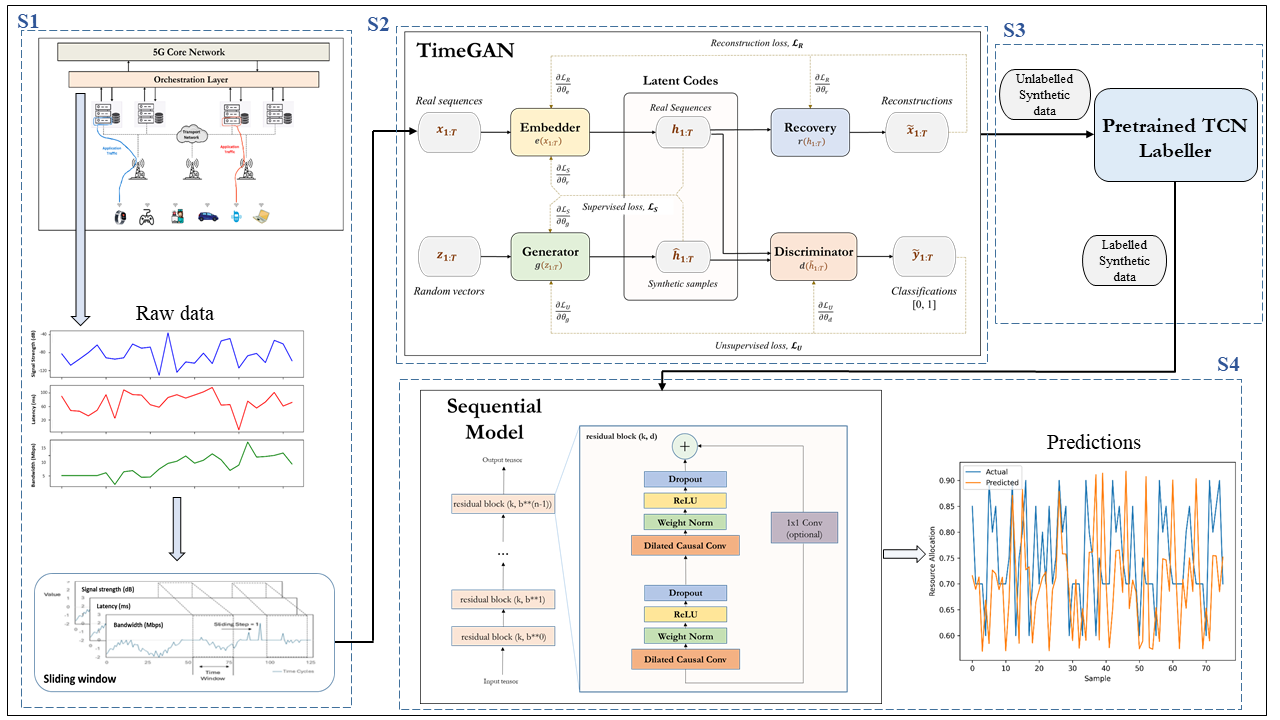

In [1]:
import pandas as pd
import numpy as np
import torch
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.7 MB/s eta 0:00:00


In [2]:
# setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# setting random seeds
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


# 1.Data Cleaning and Preprocessing

In [3]:
from data_loading import data_loading

Data loaded successfully.

Box plots for diffErent QoS metrics: 


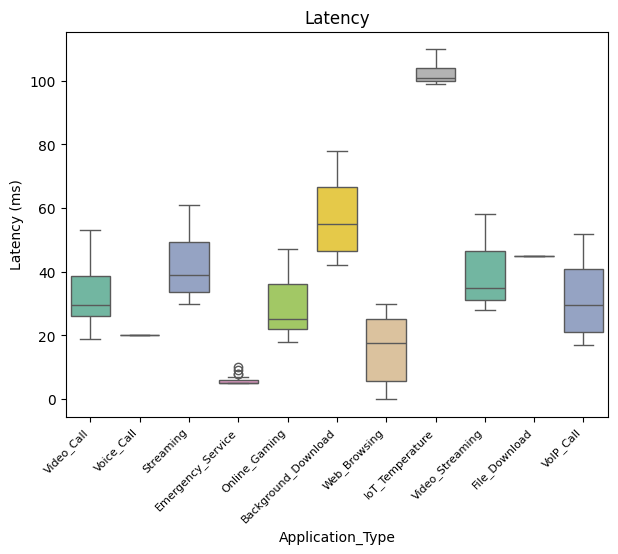

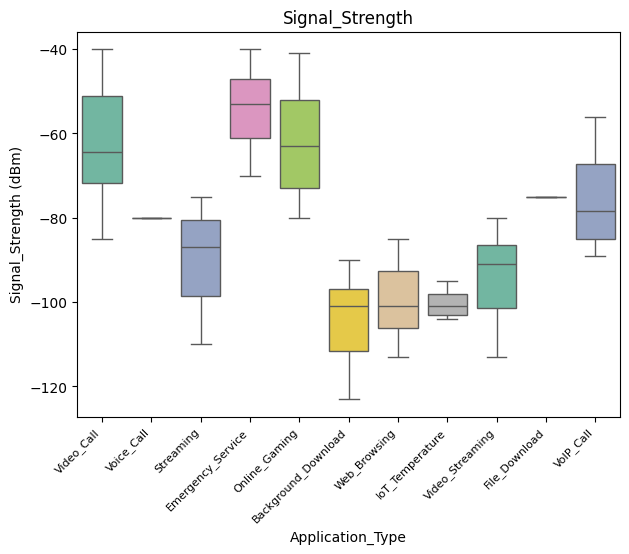

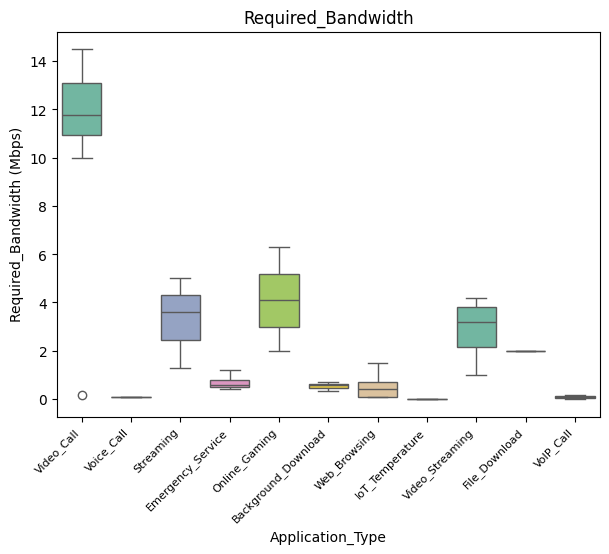

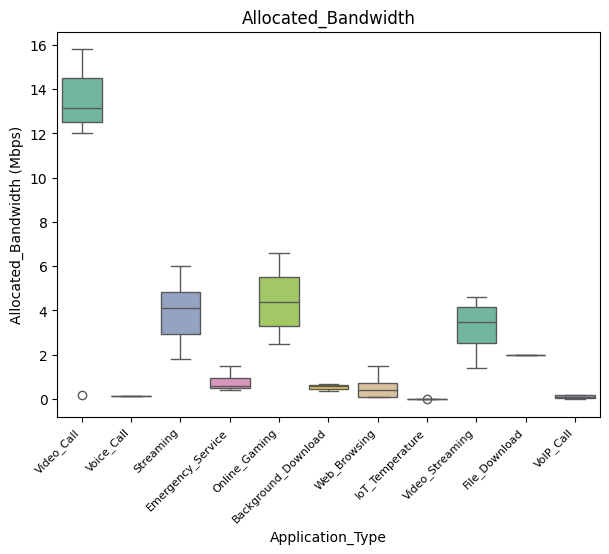


Train size: 266, Validation size: 38, Test size: 76
Data shape: torch.Size([266, 20, 5])
.
.
Dataset is ready


In [4]:
# data loading, cleaning and processing function
df, label_mapping, scaler, X_train, y_train, X_val, y_val, X_test, y_test, seq_len = data_loading('Quality of Service 5G')

#2.TimeGAN

##2(a).TimeGAN Components Overview

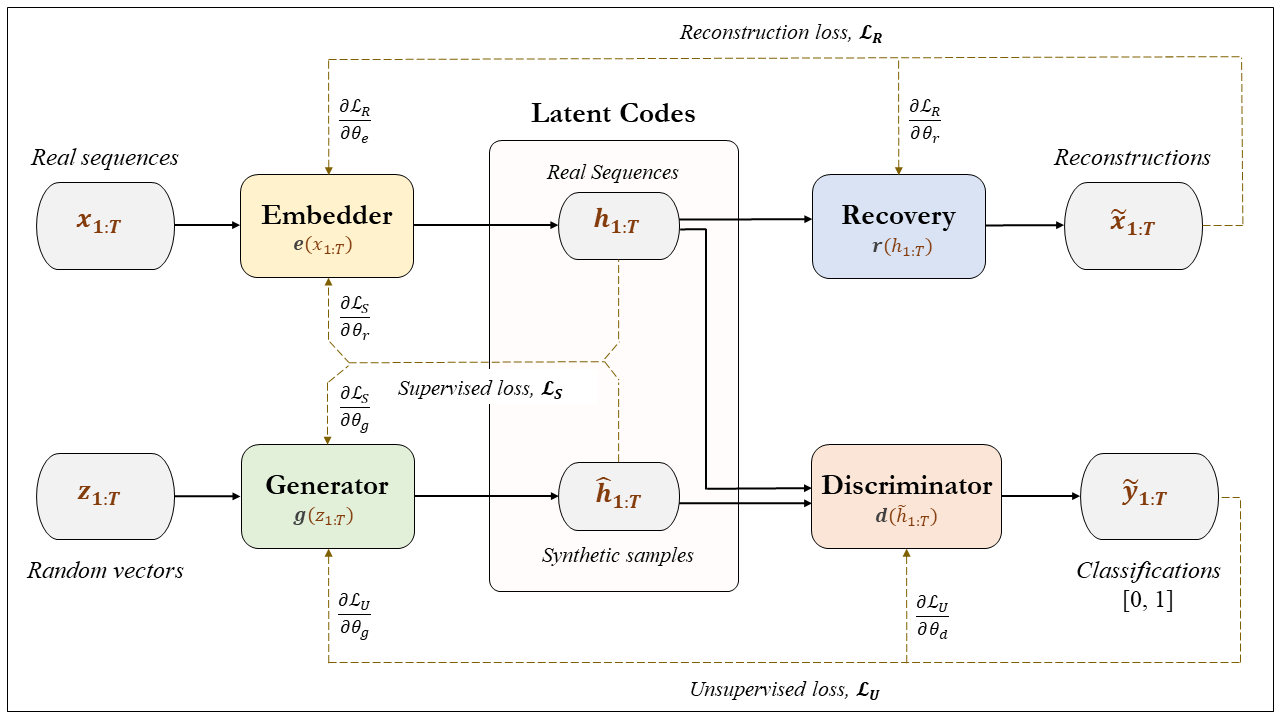

##2(b).TimeGAN Model Training

In [5]:
from timegan import timegan_training, generate_synthetic_data, save_checkpoint, reload_components, save_individual_components # functions
from timegan import Embedder, Recovery, Generator, Supervisor, Discriminator # class definitions of the different network components

In [6]:
# TimeGAN Architecture
input_dim = X_train.shape[2]  # number of features in each time step
hidden_dim = 16
latent_dim = 16
num_layers = 2

# Learning rates
lr_embedder = 0.005  # --- same as Generator/Supervisor to keep latent space mapping aligned
lr_recovery = 0.005  # --- same as embedder since it decodes Embedder's outputs
lr_supervisor = 0.005  # --- should typically have same lr as Generator since they work closely together.
                             # (On subsequent training runs I experimented with various values to see differences in outcome)
lr_generator = 0.005
lr_discriminator = lr_generator # --- start with equal discr & gen learning rates, then maybe lower it depending on
                                   # gen_loss/discr_loss plot outcomes, e.g if discr greatly outperforms gen, then lower discr learning rate


Phase 1: Autoencoder Pretraining
Pretrain Epoch [20/200], Recon Loss: 0.066164
Pretrain Epoch [40/200], Recon Loss: 0.062776
Pretrain Epoch [60/200], Recon Loss: 0.061082
Pretrain Epoch [80/200], Recon Loss: 0.057460
Pretrain Epoch [100/200], Recon Loss: 0.036916
Pretrain Epoch [120/200], Recon Loss: 0.031998
Pretrain Epoch [140/200], Recon Loss: 0.030905
Pretrain Epoch [160/200], Recon Loss: 0.022072
Pretrain Epoch [180/200], Recon Loss: 0.023552
Pretrain Epoch [200/200], Recon Loss: 0.017444

Phase 2: Supervisor Pretraining
Supervisor Epoch [20/200], Supervised Loss: 0.000701
Supervisor Epoch [40/200], Supervised Loss: 0.000387
Supervisor Epoch [60/200], Supervised Loss: 0.000260
Supervisor Epoch [80/200], Supervised Loss: 0.000197
Supervisor Epoch [100/200], Supervised Loss: 0.000157
Supervisor Epoch [120/200], Supervised Loss: 0.000129
Supervisor Epoch [140/200], Supervised Loss: 0.000111
Supervisor Epoch [160/200], Supervised Loss: 0.000092
Supervisor Epoch [180/200], Supervised L

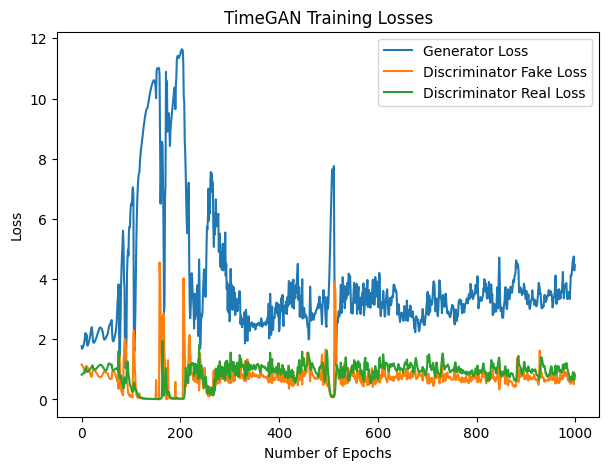



TimeGAN training completed successfully.


In [17]:
# training the TimeGAN model
embedder, recovery, generator, discriminator, supervisor, saved_checkpoint_path = timegan_training(
    Embedder, Recovery, Generator, Supervisor, Discriminator, X_train,
    input_dim, hidden_dim, latent_dim, num_layers,
    lr_embedder, lr_recovery, lr_supervisor, lr_generator, lr_discriminator,
    device
)

In [7]:
# reloading trained timegan components
embedder, recovery, generator, supervisor, discriminator = reload_components(
    Embedder, Recovery, Generator, Supervisor, Discriminator,
    X_train, device, hidden_dim=16, latent_dim=16, num_layers=2, save_path="./"
)


TimeGAN components loaded successfully from: ./


##2(c).Generating Synthetic Data

In [8]:
num_synthetic_samples = 2000
X_synth = generate_synthetic_data(
    generator, supervisor, recovery,
    num_synthetic_samples, seq_len, latent_dim, device
)

print(f"Generated synthetic data shape: {X_synth.shape}")
print(f"Real data shape: {X_train.cpu().numpy().shape}")

Generated synthetic data shape: (2000, 20, 5)
Real data shape: (266, 20, 5)


#3.Qualitative Analysis

---



##tSNE

In [10]:
from qualitative import tsne_function, temporal_quality


1. Performing t-SNE Analysis...


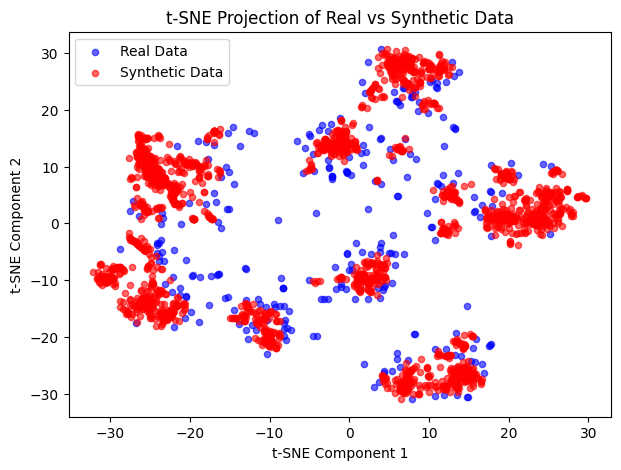

In [ ]:
tsne_function(X_train, X_synth)

##Temporal Quality Comparison

In [12]:
feature_names = ['Application_Type', 'Signal_Strength', 'Latency', 'Required_Bandwidth', 'Allocated_Bandwidth']
feature_units = ['Value', 'dBm', 'ms', 'Mbps', 'Mbps']

# ===== Application Type ===== #


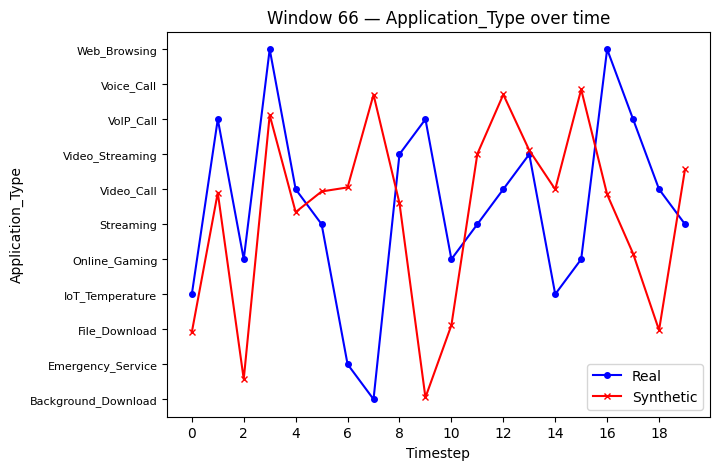

# ===== Signal Strength ===== #


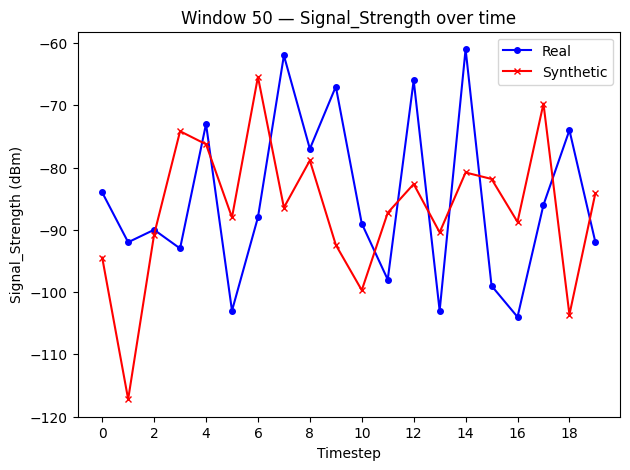

# ===== Latency ===== #


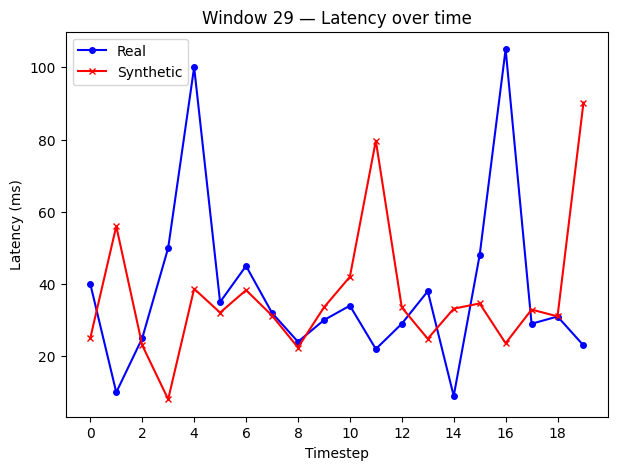

# ===== Required Bandwidth ===== #


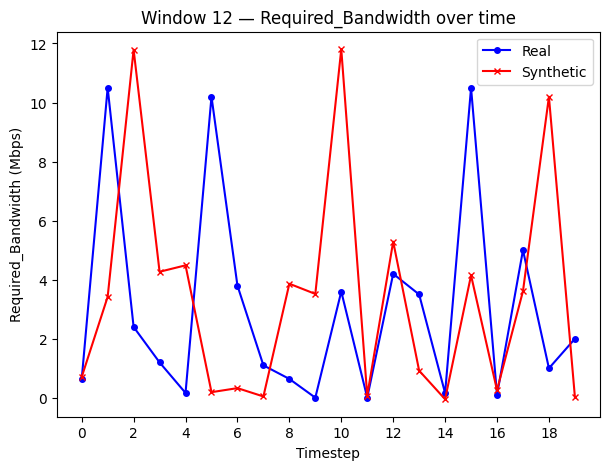

# ===== Allocated Bandwidth ===== #


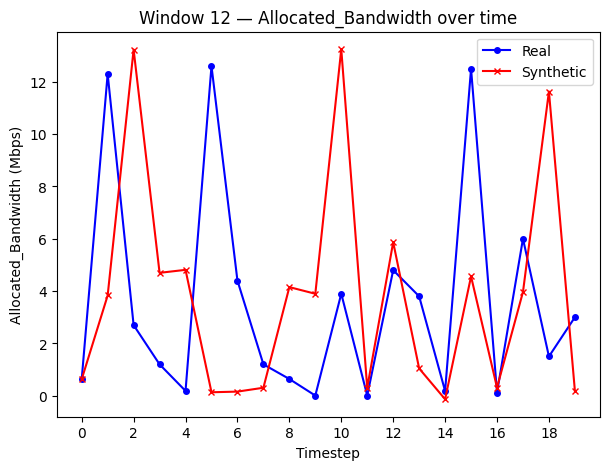

In [ ]:
temporal_quality(X_train, X_synth, feature_names, feature_units, scaler, label_mapping)

#4.Quantitative Analysis

In [9]:
# importing functions and class definitions
from quantitative import ResidualBlock, DilatedTCN, BiLSTMRegressor, RNNRegressor, GRURegressor# classes
from quantitative import train_evaluate_seqmodel, label_generator, split_synth_data # functions

##Temporal Convolutional Network

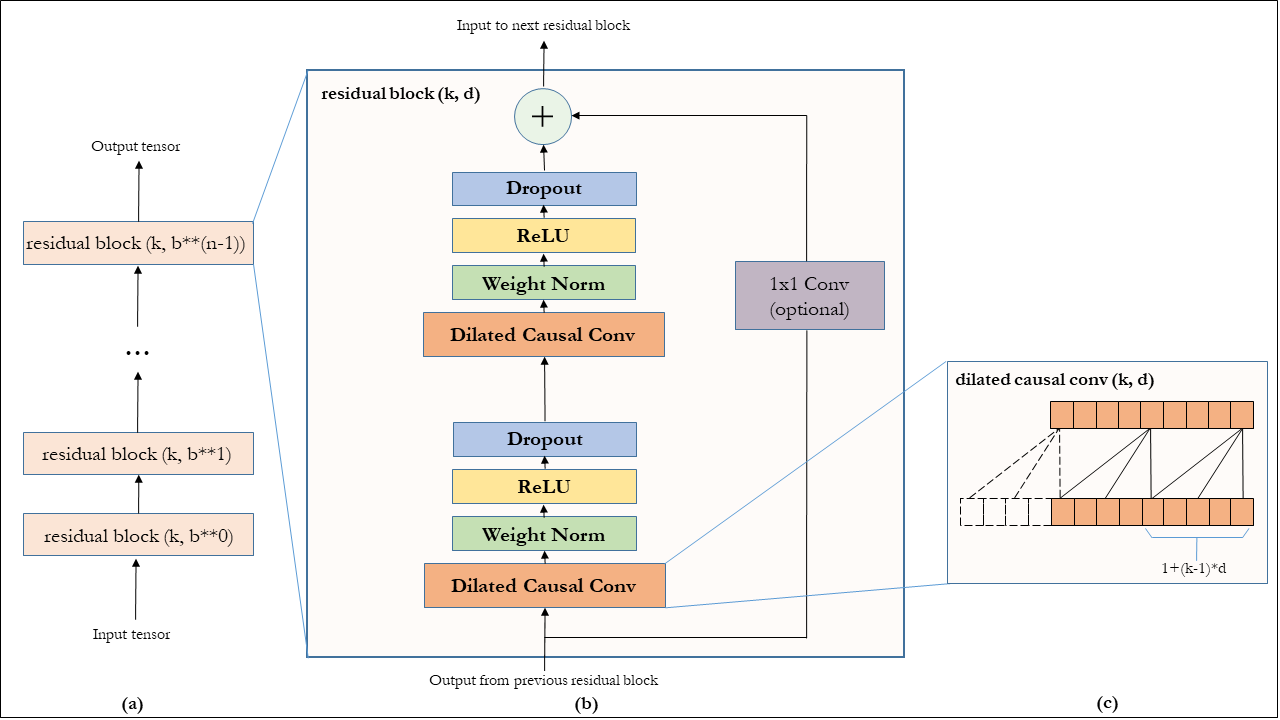

###4(a).Pretrained TCN (& TRTR)

Epoch 3/30 - Train Loss: 0.4033, Val Loss: 0.3358
Epoch 6/30 - Train Loss: 0.2812, Val Loss: 0.2226
Epoch 9/30 - Train Loss: 0.1638, Val Loss: 0.1168
Epoch 12/30 - Train Loss: 0.0776, Val Loss: 0.0402
Epoch 15/30 - Train Loss: 0.0377, Val Loss: 0.0229
Epoch 18/30 - Train Loss: 0.0549, Val Loss: 0.0536
Epoch 21/30 - Train Loss: 0.0682, Val Loss: 0.0587
Epoch 24/30 - Train Loss: 0.0562, Val Loss: 0.0375
Epoch 27/30 - Train Loss: 0.0385, Val Loss: 0.0211
Epoch 30/30 - Train Loss: 0.0307, Val Loss: 0.0184
TCN MSE: 0.0170
TCN MAE: 0.0997
TCN DTW Distance: 0.6909


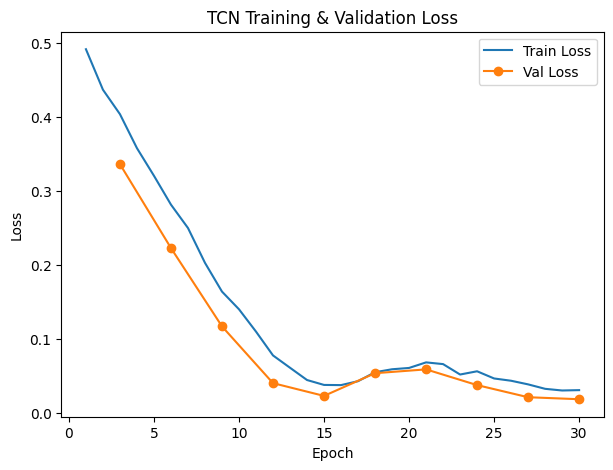

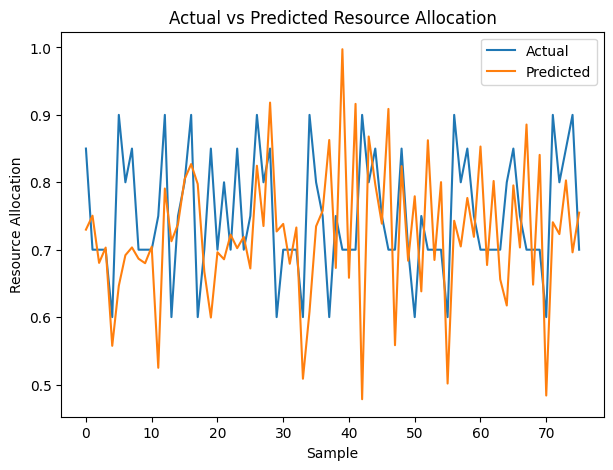

In [11]:
# Train and evaluate (TRTR)
pretrained_TCN = train_evaluate_seqmodel(
        model_architecture=DilatedTCN,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        num_epochs=30,
        lr=1e-3, # best lr after hyperparam tuning
        val_interval=3
    )

Epoch 3/30 - Train Loss: 1.0154, Val Loss: 0.9168
Epoch 6/30 - Train Loss: 0.8066, Val Loss: 0.7272
Epoch 9/30 - Train Loss: 0.6644, Val Loss: 0.5851
Epoch 12/30 - Train Loss: 0.5396, Val Loss: 0.4657
Epoch 15/30 - Train Loss: 0.4209, Val Loss: 0.3542
Epoch 18/30 - Train Loss: 0.3040, Val Loss: 0.2430
Epoch 21/30 - Train Loss: 0.2073, Val Loss: 0.1375
Epoch 24/30 - Train Loss: 0.1161, Val Loss: 0.0534
Epoch 27/30 - Train Loss: 0.0534, Val Loss: 0.0151
Epoch 30/30 - Train Loss: 0.0625, Val Loss: 0.0344
TCN MSE: 0.0372
TCN MAE: 0.1601
TCN DTW Distance: 0.8828


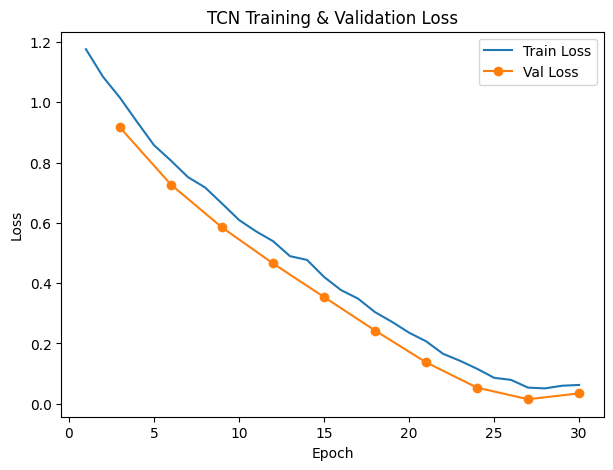

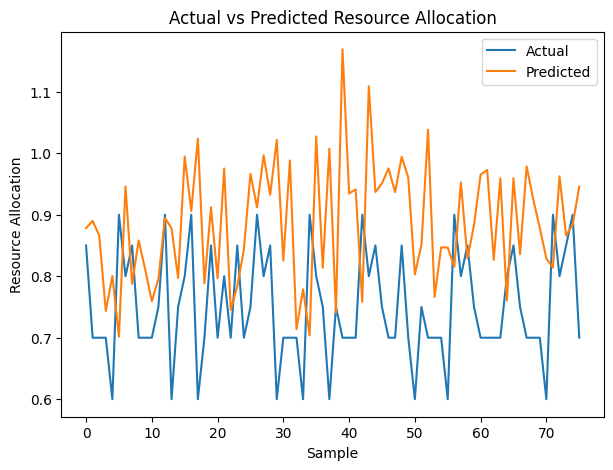

In [ ]:
# Train and evaluate (TRTR)
pretrained_TCN = train_evaluate_seqmodel(
        model_architecture=DilatedTCN,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        num_epochs=30,
        lr=1e-3, # best lr after hyperparam tuning
        val_interval=3
    )

###4(b).TRTR versus:

####(i) T(S+R)TR

*creating labels for synthetic data using pretrained TCN*

In [12]:
y_synth = label_generator(pretrained_TCN, X_synth)

y_synth shape: torch.Size([2000])


*split synthetic data*

In [13]:
(
   X_train_synth, y_train_synth,
   X_val_synth, y_val_synth,
   X_test_synth, y_test_synth,

   X_train_combined, y_train_combined,
   X_val_combined, y_val_combined

) = split_synth_data(X_train, X_synth, y_train, y_synth)

Epoch 3/30 - Train Loss: 0.3889, Val Loss: 0.3486
Epoch 6/30 - Train Loss: 0.3053, Val Loss: 0.2743
Epoch 9/30 - Train Loss: 0.2306, Val Loss: 0.1985
Epoch 12/30 - Train Loss: 0.1590, Val Loss: 0.1252
Epoch 15/30 - Train Loss: 0.0897, Val Loss: 0.0634
Epoch 18/30 - Train Loss: 0.0421, Val Loss: 0.0198
Epoch 21/30 - Train Loss: 0.0273, Val Loss: 0.0076
Epoch 24/30 - Train Loss: 0.0411, Val Loss: 0.0155
Epoch 27/30 - Train Loss: 0.0428, Val Loss: 0.0120
Epoch 30/30 - Train Loss: 0.0300, Val Loss: 0.0061
TCN MSE: 0.0182
TCN MAE: 0.1087
TCN DTW Distance: 0.7233


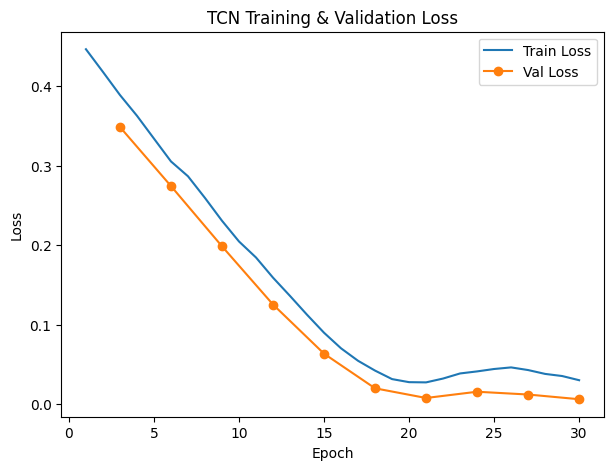

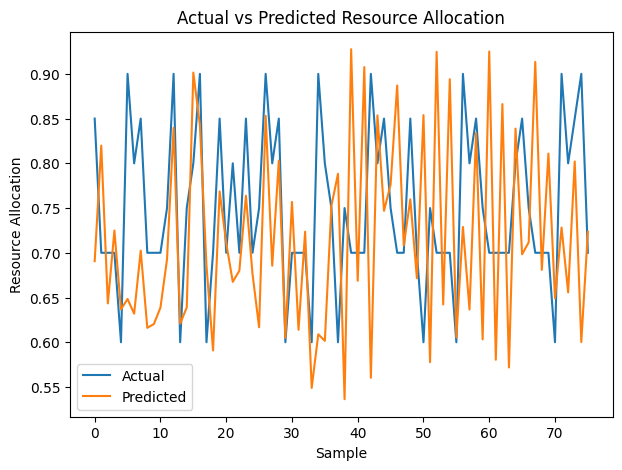

In [ ]:
# Train and evaluate T(S+R)TR
TCN_2 = train_evaluate_seqmodel(
        model_architecture=DilatedTCN,
        X_train=X_train_combined, y_train=y_train_combined,
        X_val=X_val_combined, y_val=y_val_combined,
        X_test=X_test, y_test=y_test,
        num_epochs=30,
        lr=1e-3,
        val_interval=3
    )

####(ii) TSTR

Epoch 3/30 - Train Loss: 0.3018, Val Loss: 0.2546
Epoch 6/30 - Train Loss: 0.1806, Val Loss: 0.1393
Epoch 9/30 - Train Loss: 0.0905, Val Loss: 0.0554
Epoch 12/30 - Train Loss: 0.0319, Val Loss: 0.0094
Epoch 15/30 - Train Loss: 0.0198, Val Loss: 0.0066
Epoch 18/30 - Train Loss: 0.0377, Val Loss: 0.0183
Epoch 21/30 - Train Loss: 0.0390, Val Loss: 0.0130
Epoch 24/30 - Train Loss: 0.0234, Val Loss: 0.0040
Epoch 27/30 - Train Loss: 0.0162, Val Loss: 0.0027
Epoch 30/30 - Train Loss: 0.0148, Val Loss: 0.0060
TCN MSE: 0.0195
TCN MAE: 0.1129
TCN DTW Distance: 0.7566


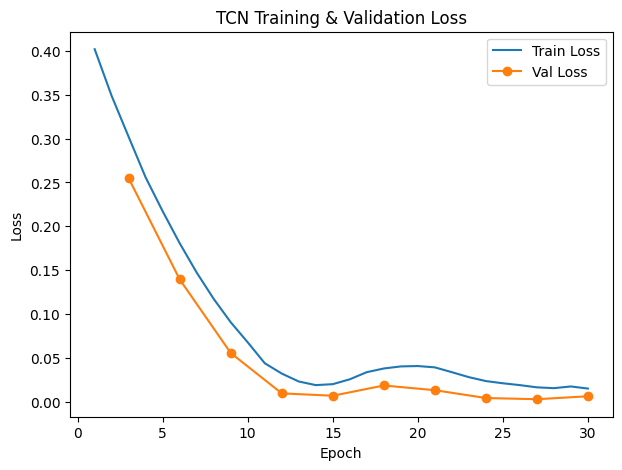

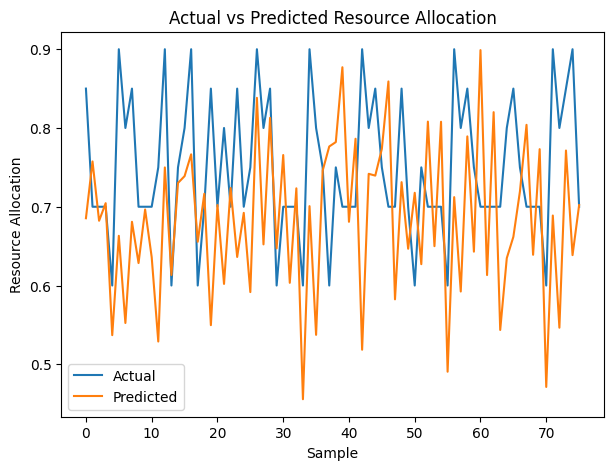

In [15]:
# Train and evaluate T(S+R)TR
TCN_3 = train_evaluate_seqmodel(
        model_architecture=DilatedTCN,
        X_train=X_train_synth, y_train=y_train_synth,
        X_val=X_val_synth, y_val=y_val_synth,
        X_test=X_test, y_test=y_test,
        num_epochs=30,
        lr=1e-3,
        val_interval=3
    )

####(iii) TRTS

Epoch 3/30 - Train Loss: 0.2397, Val Loss: 0.2172
Epoch 6/30 - Train Loss: 0.1587, Val Loss: 0.1399
Epoch 9/30 - Train Loss: 0.0887, Val Loss: 0.0815
Epoch 12/30 - Train Loss: 0.0440, Val Loss: 0.0473
Epoch 15/30 - Train Loss: 0.0313, Val Loss: 0.0456
Epoch 18/30 - Train Loss: 0.0438, Val Loss: 0.0589
Epoch 21/30 - Train Loss: 0.0412, Val Loss: 0.0556
Epoch 24/30 - Train Loss: 0.0383, Val Loss: 0.0446
Epoch 27/30 - Train Loss: 0.0284, Val Loss: 0.0390
Epoch 30/30 - Train Loss: 0.0276, Val Loss: 0.0380
TCN MSE: 0.0370
TCN MAE: 0.1794
TCN DTW Distance: 1.8565


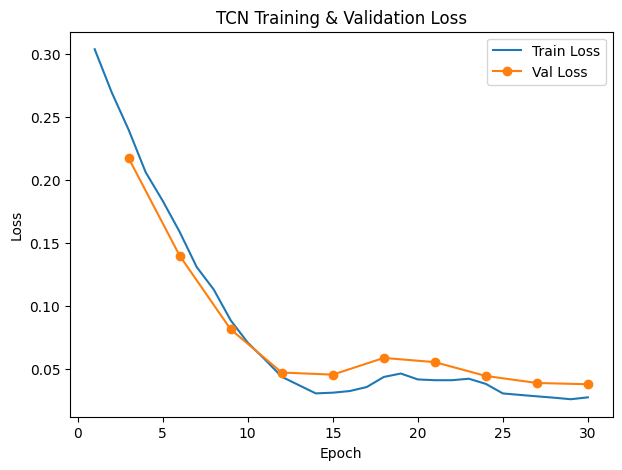

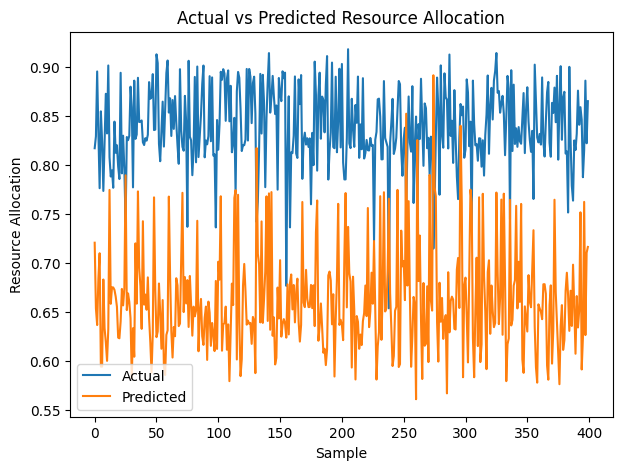

In [ ]:
# Train and evaluate TRTS
TCN_4 = train_evaluate_seqmodel(
        model_architecture=DilatedTCN,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test_synth, y_test=y_test_synth,
        num_epochs=30,
        lr=1e-3,
        val_interval=3
    )

##Recurrent Neural Networks